In [1]:
## Preamble: Package Loading
import numpy as np
from sklearn import linear_model
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import itertools as iter
import os
import datetime as dt
import json
import kernel as kr
import psc_sumdisp as psd 
# Preamble working directory retreival
wkng_folder = os.getcwd()

<h2> 2 Required Functions </h2>

<h3> 2.1 Merging and Differencing Function </h3>

In [2]:
def mrg_dff(dp_in,di_in,inpt):
    """
INPUTS 
  dp_in                  (df) panel dataframe 
  di_in                  (df) instruments dataframe
  inpt                   (dict) Containing the following elements
    inpt['tin']          (str) time index column name
    inpt['cin']          (str) cross section index column name
    inpt['ncs']          (int) number of cross sections
    inpt['inc_vec']       (lst) of list of binary vectors 
      inpt['inc_vec'][i]  (lst) of binary vectors listing which instruments in inc are relevant to ith crs
    
OUTPUTS
  out[0]             (df) dp_in and di_in merged on tin for each cin and 1st differenced
  out[1]             (df) dp_in and di_in merged on tin for each cin 
    """
    # Extracting variables from input dictionary
    tin = inpt['tin']
    cin = inpt['cin']
    ncs = inpt['ncs']
    inst_incl_vec = inpt['inc_vec']
    
    # Looping over each cross section
    for i in range(ncs):
        # Merging panel and instrument df on tin for ith cross section
        inst_no_tin = di_in.drop(inpt['tin'],axis=1).copy()
        inc_vec_for_i = inst_incl_vec[i]
        inst_only_relev_for_i = pd.DataFrame(inst_no_tin.values.dot(np.diag(inc_vec_for_i)))
        inst_only_relev_for_i.columns = inst_no_tin.columns 
        inst_only_relev_for_i = pd.concat([data_inst.loc[:,inpt['tin']] ,
                                           inst_only_relev_for_i] , axis=1)
        b1 = pd.merge(dp_in.loc[dp_in[cin]== i+1,:],inst_only_relev_for_i,how = 'inner', on = tin)
        # Initializing the temp difference matrix 
        b2 = b1.loc[1:,[tin]+[cin]] 
        # Looping over all the column names in b1
        for nm in b1.columns[2:].tolist():
            # 1st Differencing nm column of b1
            b2[''.join(['D',nm])] = (b1.loc[:,nm].values - b1.loc[:,nm].shift(1).values)[1:]
        if i == 0:
            # Initializing final matrix out
            out1 = b2
            out2 = b1
        elif i > 0:
            # Concatenating b2 to out
            out1 = pd.concat([out1,b2],axis =0)
            out2 = pd.concat([out2,b1],axis =0)
            out = [out1 , out2]
    return out

<h3> 2.2 Cross Validation Partition Generation Function </h3>

In [3]:
def k_subs(k,ntp,ncs):
    """
INPUTS
 k       (int) number of partition memebers
 ntp     (int) number of time periods

OUTPUTS
 out                    (list) containing the following elements
   out[0]               (list of tuples) index numbers for instrument partitions
     out[0][i]          (tuples of list) ith instrument partition
         out[0][i][0]   (list) of row numbers in the ith part. training set for instruments
         out[0][i][1]   (list) of row numbers in the ith part. test set for instruments
   out[1]               (list of tuples) index numbers for panel data partitions
     out[1][i]          (tuples of list) ith panel data partition
         out[1][i][0]   (list) of row numbers in the ith part. training set for panel data
         out[1][i][1]   (list) of row numbers in the ith part. test set for panel data
    """
    # List of row index numbers for each cross section
    a0 = [i for i in range(ntp)]
    # Length of the first k-1 partition list
    n_sl = int(np.floor(ntp)/k)
    # Generating the k-1 partitions as a lists of disjoint exhaustive lists 
    k_grp = [[a0.pop(np.random.randint(1,ntp-i-j*n_sl)) for i in range(n_sl)] 
                                                                for j in range(k-1)]
    # Adding in the last partition
    k_grp.append(a0)
    # Inintializing list of train / test tuples 
    in_indx = []
    pan_indx = []
    for i in range(k):
        # Initializing the ith train list
        a2 = []
        # Initializing the list of partitions whose union is a training set
        a3 = list(range(k))
        # Removing the test set index
        del a3[i]
        for j in a3:
            # Taking the union of all training set partition lists
            a2 = sorted(a2 + k_grp[j])
        # Creating the ith (training,test) tuple
        a4 = (a2,sorted(k_grp[i]))
        # Appending to full list
        in_indx.append(a4)
        a5 = a2
        a6 = sorted(k_grp[i])
        for j in range(1,ncs):
            a5 = a5 + (np.array(a2)+j*ntp).tolist()
            a6 = a6 + (np.array(sorted(k_grp[i]))+j*ntp).tolist()
        a7 = (a5,a6)
        pan_indx.append(a7)
        
    return([in_indx,pan_indx])    

<h3> 2.3 OLS function </h3>

In [4]:
def ols(df,inpt):
    """
INPUTS
df                (pandas df) Data Frame with all regressors
inpt              (dict) Dictionary with the following
  inpt['dep']     (string) Name of dependent variable contained in df
  inpt['reg']     (list of strings) names of regressors in df 
  inpt['cons']    (0,1) Indicator for whether a constant should be included

OUTPUTS 
out               (list of lists) List of the following
  out[0]          (list) Estimated coefficients
  out[1]          (list) Residuals
  out[2]          (list) Estimated conditional expectation
    """
    # Extracting input variables
    dep = inpt['dep']
    reg = inpt['reg']
    cons = inpt['cons']
    # Determining length of df (number of obs)
    n = df.shape[0]
    # Extracting Dependent Variable from df
    Y = df.loc[:,dep].values.reshape(n,1)
    # Extracting Regressors from df
    if len(reg) == 1:
        X = df.loc[:,reg].values.reshape(n,1)
    elif len(reg) > 1: 
        X = df.loc[:,reg].values
    # Adding column of ones if a constant is included
    if cons == 1: 
        X = np.hstack((np.ones((n,1)),X))
    # Estimated regression coefficients
    alpha = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(Y))
    # Estimated Conditional Expectation
    Yhat = X.dot(alpha)
    # Residuals of the regression
    res = Y - X.dot(alpha)
    # Constructing output list of lists
    out = [alpha.T.tolist()[0],res.T.tolist()[0],Yhat.T.tolist()[0]]
    return out

<h3> 2.4 Panel Lasso Estimator </h3>

In [5]:
def pan_lasso(l_dp,l_inpt):
    """
INPUTS
l_dp                 (df) all panel regression variables 
l_inpt               (dict) Containing the following elements
  l_inpt['dep']        (str) name of dependent variable
  l_inpt['ex_nm']      (str) name of all exogenous variables
  l_inpt['ins_nm']     (str) name of all instruments
  l_inpt['alph']       (flt) lasso penalty parameter
  l_inpt['ncs']        (int) number of cross sections
  l_inpt['epsil']      (flt) threshold for averaging "non zero" coefficients
  
OUTPUTS
out            (lst) with the following elements
 out[0]        (lst) Estimated coefficients
 out[1]        (lst) containing the following elements
   out[1][j]   (lst) binary vector indicating the non zero ceofficients for each crs
    """
    
# Extracting variables from input dictionary
    l_dep_nm = l_inpt['dep']
    l_ex_nm = l_inpt['ex_nm']
    l_ins_nm = l_inpt['ins_nm']
    l_alph = l_inpt['alph']
    l_epsil = l_inpt['epsil']
    n_exo = len(l_ex_nm)
    ncs = l_inpt['ncs']
    t_inst = len(l_ins_nm)
    # Initializing the coefficient list
    excf1 = []

    # Estimating the coefficients on the exogenous regressors
    for k in range(inpt['ncs']):
        # Extracting the kth cross sections data 
        dsl = l_dp.loc[l_dp['crs']==k+1,:]
        #Initializing the regression model
        lin_reg = linear_model.LinearRegression()
        #Fitting the regression model
        lin_reg.fit(dsl.loc[:,l_ex_nm+l_ins_nm].values,
                    dsl.loc[:,l_dep_nm].values.reshape(dsl.shape[0],1))
        # Appending the est coeff for exogenous regressors to coeff list
        excf1.append([lin_reg.coef_[0][i] for i in range(n_exo)])

    # Averaging coefficient values over cross sections  
    excf = [np.mean([excf1[i][j] for i in range(len(excf1))]) for j in range(n_exo)]
    # Generating the name of the modified dependent variable
    adep_nm = ''.join(['a',l_dep_nm])
    # Generating the modified dependent variable
    l_dp[adep_nm] = (l_dp.loc[:,l_dep_nm].values.reshape(l_dp.shape[0],1)
                     -l_dp.loc[:,l_ex_nm].values.dot(np.array(excf).reshape(n_exo,1)))

    # Initialzing the list of estimated lasso coefficients                 
    ain_cf1 = []
    for k in range(ncs): 
        # Extracting modified dep and indep regressor for crs k 
        ds2 = l_dp.loc[l_dp['crs']==k+1,:]
        # Initializing lasso regression model
        lasso_reg = linear_model.Lasso(alpha = l_inpt['alph'])
        # Fitting the regression model
        lasso_reg.fit(ds2.loc[:,l_ins_nm].values,
                      ds2.loc[:,adep_nm].values.reshape(ds2.shape[0],1))
        # Appending lasso coefficient to list
        ain_cf1.append(list(lasso_reg.coef_))

    # Initializing set of estiamated coeff with those one the exogenous variables
    ain_cf = excf
    # generating the final averged values of each coefficient
    for j in range(len(ain_cf1[0])): 
        # Collecting all coeff estimated on jth inst greater than threshold l_epsil
        a = [ain_cf1[i][j] for i in range(len(ain_cf1)) if np.abs(ain_cf1[i][j]) > l_epsil]
        if not a:
            # If a is an empty list inst not selected in any crs so append a zero
            ain_cf.append(0)
        else:
            # Averging if a is non empty
            ain_cf.append(np.mean(a))    

    # Generating a list of lists where ain_cf_rm[j][i]=1 if the |coeff| on the ith inst
    # for the jth cross section is greater than l_epsil
    ain_cf_rm = [[1,1] + [int(np.abs(ain_cf1[j][i])>l_epsil) 
                            for i in range(len(ain_cf1[0]))] 
                            for j in range(len(ain_cf1))]
    # Function output
    out = [ain_cf, ain_cf_rm]
    return out

<h3> 2.5 Crossvalidated Panel Lasso Estimator </h3>

In [6]:
def pan_lasso_cv(data_pan_mr,data_pan_mrdf,inpt_ls):
    
    """
INPUTS
  data_pan_mr            (df) panel where crs regs are merged with insts
  data_pan_mrdf          (df) panel where crs regs are merged with insts and 1st differenced
  inpt_ls                (dict) of the following elements
    inpt_ls['cv']        (int) indicator for whether cross validation is done
    inpt_ls['dep']       (str) names of differenced dependent variable in lasso reg
    inpt_ls['odep']      (str) names of non differenced dependent variable
    inpt_ls['ex_nm']     (lst) names of differenced exogenous variables
    inpt_ls['oex_nm']    (lst) names of non differenced exogenous variables
    inpt_ls['ins_nm']    (lst) names of differenced instruments
    inpt_ls['oins_nm']   (lst) names of non difference instruments
    inpt_ls['alph']      (flt) initial alpha tuning parameter
    inpt_ls['epsil']     (flt) threshold for averaging "non zero" coefficients
    inpt_ls['cin']       (str) name of crs section variable
    inpt_ls['tin']       (str) name of time variable
    inpt_ls['n_alphs']   (int) number of different alphas tried
    inpt_ls['n_parts']   (int) number of partition elements 
    inpt_ls['ntp']       (int) number of time periods
    inpt_ls['ncs']       (int) number of cross sections

OUPUTS
    out             (lst) with the following elements
      out[0]        (lst) Estimated coefficients
      out[1]        (lst) containing the following elements
        out[1][j]   (lst) binary vector indicating the non zero ceofficients for each crs
      out[2]        (lst) list of mean meansquared errors 
      out[3]        (lst) cross validated alpha tuning parameter
    """
                    
    #Extracting info from dictionary
    n_alphs = inpt_ls['n_alphs']
    oins_nm = inpt_ls['oins_nm']
    oex_nm = inpt_ls['oex_nm']
    odep = inpt_ls['odep']
    n_parts = inpt_ls['n_parts']
    n_alphs = inpt_ls['n_alphs'] 
    cin = inpt_ls['cin']
    tin = inpt_ls['tin']
    ncs = inpt_ls['ncs']
    ntp = inpt_ls['ntp'] 
    cv = inpt_ls['cv']

    if cv == 0:
        # Estimating lasso regression with orginal input alpha
        ls_soln = pan_lasso(data_pan_mrdf,inpt_ls)
        out = ls_soln + ['none'] + ['none']

    elif cv == 1:  
        # Generating partitions
        indx = k_subs(n_parts,ntp-1,ncs)

        # Initializing carrier lists
        all_msr = []
        trl_alph = []

        # For each value of lasso tuning parameter
        for k in range(5,n_alphs+6):
            # Initializing mean squared error list for each partition
            msr = []
            # Setting the value of the lasso tuning parameter
            inpt_ls['alph'] = k/n_alphs
            # Appending the current lasso tuning parameter
            trl_alph.append(k/n_alphs)
            # For each of the training testing set combinations
            for part in range(n_parts):
                # Merged and differenced training set
                trn_mrdf = data_pan_mrdf.iloc[indx[1][part][0],:].copy()
                # Merged and differenced testing set
                tst_mrdf = data_pan_mrdf.iloc[indx[1][part][1],:].copy()
                # Merged only testing set
                tst_mr = data_pan_mr.iloc[indx[1][part][1],:].copy()
                # lasso estimation on training data set
                lcf = pan_lasso(trn_mrdf,inpt_ls)
                # Initializng list of allresiduals for each cross section 
                all_res = []
                # for each cross section
                for i in range(ncs):
                    # Extracting the un difference test regressor matrix for crs i
                    c1 = tst_mr.loc[tst_mr[cin]==i+1, oex_nm + oins_nm ].values
                    # Creating the diagonal selection matrix for crs i
                    c2 = np.diag(lcf[1][i])
                    # Reshaping Estimated lasso coefficient matrix
                    c3 = np.array(lcf[0]).reshape(len(oex_nm + oins_nm),1)
                    # Computing partial estimated values (no constant term included)
                    c4 = c1.dot(c2).dot(c3)
                    # Computing non centered residuals (no constant term included)
                    res1 = tst_mr.loc[tst_mr[cin]==i+1,odep].values.reshape(len(c4),1) - c4
                    # Computing centered squared residuals
                    cres = (res1 - np.mean(res1))**2
                    # Concatenating sqr residuals of ith cross section to all_res
                    all_res = all_res + cres.tolist()
                # Appending the mean sqrd residuals for the npart th trn and test set 
                msr.append(np.mean(all_res))
            # Appending the mean of mean sqrd residuals for all partitions   
            all_msr.append(np.mean(msr))

        # Index of smallest mean msr values
        ax = all_msr.index(min(all_msr))
        # alpha value that produces smallest mean_msr
        cv_alph = trl_alph[ax]

        # Running Lasso with cv alpha
        inpt_ls['alpha'] = cv_alph
        # Estimating lasso regression with cros validated alpha
        ls_soln = pan_lasso(data_pan_mrdf,inpt_ls)
        out = ls_soln
        out.append(all_msr)
        out.append(cv_alph)

    return out

<h3> 2.6 Panel Data Estimator </h3>

In [7]:
def panel_fe(dp_in,di_in,inpt):
    """
INPUTS
dp_in                     (pandas df) df with dependent var. and all exogenous regs
di_in                     (pandas df) df with all instruments
inpt                      (dict) Dictionary with the following
  inpt['dep']               (string) Name of dependent variable contained in dp
  inpt['reg']               (list of strings) names of exogenous regressors
  inpt['cin']               (string) name of crossection index in dp
  inpt['tin']               (string) name of time index in dp
  inpt['ncs']               (int) number of crossections
  inpt['alph']              (flt) penalty value for lasso estimation
  inpt['epsil']             (flt)  threshold for averaging "non zero" coefficients
  inpt['lasso']             (int) indicator for whether subset selection with lasso is done
  inpt['in_nm']             (list of lists of strings) with the following components
    input['in_nm'][i-1]       (list of names) names of instruments relevant to crs i 
  

OUTPUTS 
out               (list of lists) List of the following
  out[0]          (list) Estimated coefficients
  out[1]          (list) list of all relevant instrument
  out[2]          (list) Estimated error terms Vi_j
  """

    ## Extracting Variables from inpt dictionary
    dep = inpt['dep']
    reg = inpt['reg']
    in_nm = inpt['in_nm']
    cin = inpt['cin']
    tin = inpt['tin']
    ncs = inpt['ncs']
    lasso = inpt['lasso']
    di  = di_in
    dp  = dp_in

    
    
    
    ## Constructing a df of all instrument relevant to at least 1 crossection
    # Initializing the set of all included instruments as the 1st set relevant inst
    inc = set(in_nm[0])
    # Collecting rest of relevant instruments
    for i in range(len(in_nm)):
        # Union of inc and ith set of relevant instruments
        inc = inc|set(in_nm[i])
    # All included Instruments listed in order index order
    inc = [''.join(['W',str(i)]) for i in range(1,di.shape[1]) if ''.join(['W',str(i)]) in inc]
    # df with time index and all included instruments
    di_inc = di.loc[:,[tin] + inc]

    # List of logical vectors (as list) of which instruments in inc are relevant to ith crs
    in_vec = [[ 1 if inc[i] in in_nm[j] else 0 for i in range(len(inc))]
                  for j in range(ncs)]

    # First differenced included instrument df
    Di = di_inc.loc[:,[tin]]
    for j in range(0,len(inc)):
        # Adding D to name of jth instrument in inc
        D_nm = ''.join(['D', di_inc.columns[j+1]])
        # First difference of jth instrument in inc
        Di[D_nm] = (di_inc.loc[:,di_inc.columns[j+1]].values 
                    - di_inc.loc[:,di_inc.columns[j+1]].shift(1).values)

    ## Constructing Panel Version of relevant instrument data
    for i in range(ncs):
        # Initializing differenced panel template df
        a1 = Di.loc[:,tin].copy()
        # Adding the crossection variable
        a1 = pd.concat([a1,pd.DataFrame(np.ones((di_inc.shape[0],1))*(i+1)
                                        ,columns = [cin])],axis = 1)
        # Initializing the panel template df
        b1 = a1
        # Product of Di with in_vec[i-1] s.t. inst. not relevant to i are zero 
        a2 = pd.DataFrame(Di.iloc[:,1:].values.dot(np.diag(in_vec[i]))
                          ,columns = Di.columns[1:])
        # Product of di_inc with in_vec[i-1] s.t. inst. not relevant to i are zero
        b2 = pd.DataFrame(di_inc.iloc[:,1:].values.dot(np.diag(in_vec[i]))
                          ,columns = di_inc.columns[1:])
        # Concatenating a2 onto panel template adding [cin] and [tin]
        a2 = pd.concat([a1,a2],axis = 1)
        # Concatenating b2 onto panel template adding [cin] and [tin]
        b2 = pd.concat([b1,b2],axis = 1)
        if i == 0:
            # if  i = 0 initialize final differenced panel df
            Ddi_pan = a2.iloc[1:,:]
            # if i = 0 initialize final panel df
            di_pan = b2
        elif i > 0: 
            # if i > 0 add ith crosssection rows onto final
            Ddi_pan = pd.concat([Ddi_pan,a2.iloc[1:,:]], axis = 0)
            # if i > 0 add ith crosssection rows onto final
            di_pan =  pd.concat([di_pan,b2], axis = 0)

    ## First Difference dependent and exogenous regressor matrix..
    for i in range(1,ncs+1):
        # Initializing panel template df
        c1 = dp.loc[dp[cin]== i,[cin]+[tin]].copy() 
        # First differencing al relevant variables for i crs
        for j in [inpt['dep']] + inpt['reg']:
            c1[''.join(['D',j])] = (dp.loc[dp[cin]== i,j].values 
                        - dp.loc[dp[cin]== i,j].shift(1).values)
        if i == 1:
            # If i = 1 initialize final panel df
            c2 = c1.iloc[1:,:]  
        elif i > 1:
            # If i > 1 add onto final panel df
            c2 = pd.concat([c2,c1.iloc[1:,:]],axis = 0)

    ## OLS estimation
    # Merging all differenced panel df's together
    Ddi_pan = pd.merge(c2,Ddi_pan,on=[cin,tin],how = 'inner')
    # List of all regressor names in Ddi_pan for use in ols()
    Dregs = ([''.join(['D',reg[i]]) for i in range(len(reg))] 
            + [''.join(['D',inc[i]]) for i in range(len(inc))])

    if lasso == 0:
        # Initializing ols object
        ols_reg =linear_model.LinearRegression()
        # Fitting the OLS regression
        ols_reg.fit(Ddi_pan.drop([cin]+[tin]+[''.join(['D',dep])],axis=1),
                    Ddi_pan.loc[:,''.join(['D',dep])])
        # Extracting estimated regression coefficients
        ols_out = ols_reg.coef_.tolist()
        # Initializing the ceofficient vector with zero's for regressors irrelevant to all crs
        ex_cf = ols_out[:len(reg)]
        # List of ex regressor column names in di
        fins_nm = di_in.columns.tolist()[len(reg)-1:]
        fregs = reg + fins_nm
        for i in range(len(fins_nm)):
            if inc.count(fins_nm[i]) > 0:
                # If the ith inst in di is in inc append the corr. coefficient to ex_cf
                ex_cf.append(ols_out[inc.index(fins_nm[i])+len(reg)])
            elif inc.count(fins_nm[i])==0:
                # If the ith inst in di is not in inc append a zero
                ex_cf.append(0)  
        # List of lists of indicator of relevant ex and inst to each cross section      
        rev_cf = [[1]*len(reg) + [in_nm[i].count(fins_nm[j]) 
                                  for j in range(len(fins_nm))] 
                                  for i in range(len(in_nm))]

    elif lasso == 1:
        # Input dictionary for Lasso Estimation
        l_inpt = {'dep': ''.join(['D',dep]),
                  'odep': inpt['dep'],
                  'ex_nm': [''.join(['D',reg[i]]) for i in range(len(reg))],
                  'oex_nm': reg,
                  'ins_nm': [''.join(['D',inc[i]]) for i in range(len(inc))],
                  'oins_nm': inpt['in_nm'][i], 
                  'alph': inpt['alph'],'epsil':inpt['epsil'],'cin': inpt['cin'],
                  'tin' : inpt['tin'], 'n_alphs': inpt['n_alphs'], 'n_parts': inpt['n_parts'],
                  'ntp': inpt['ntp'],'ncs':inpt['ncs']
                     }
        # Estimation by panel lasso
        out = pan_lasso_cv(Ddi_pan,l_inpt)
        # Extracting estimated coefficients
        ex_cf = np.array(out[0]).reshape(len(out[0]),1)
        # Relevant instrument matrix
        rev_cf = out[1]

    # Constucting a panel df of estimated errors Vj,i
    for i in range(1,ncs+1):
        # np.array of dep variable values for ith crs
        d1 = dp.loc[dp[cin] == i,[dep]].values
        # df of exogenous regressor values for ith crs
        d21 = dp.loc[dp[cin] == i ,[tin]+reg]
        # merging d21 and d22 making a df with all RHS regressors 
        d23 = pd.merge(d21,di,on = [tin], how = 'inner')
        # d2
        d2 = d23.drop(tin,axis=1).values.dot(np.diag(rev_cf[i-1])).dot(ex_cf)
        # Residual of time varying component 
        d3 = d1.reshape(d1.shape[0],1) - d2.reshape(d2.shape[0],1)
        # Centered residula of time varying component
        d3 = d3 - np.mean(d3)
        if i == 1:
            # if i = 1 initialize panel df
            p_res = [list(d3.T[0])]
        elif i > 1:
            # if i > 1 add onto p_res
            p_res.append(list(d3.T[0]))

    # Output of the function
    pan_out = [ex_cf,inc , p_res, rev_cf]

    return pan_out

<h3> 3.1 Data Loading </h3>

In [8]:
input_filename = 'pscdata_7_17_1126.json'
data_file = '/Users/ericpenner/Google_Drive/Research/pan_sel_cntrl/data'
input_file_full = ''.join([data_file,'/',input_filename])
with open(input_file_full) as f_obj: 
    pscdata = json.load(f_obj)
inpt = pscdata[0][0].copy()    

<h3> 3.2 Input Dictionary Setup </h3>

In [9]:
# Indicator for  whether in this run the subset of instrument relvant to each crs is known.
inpt['kwnsub'] = 0

# Indicator for whether residuals are observed
inpt['orcl'] = 0
inpt['lasso'] = 1
inpt['dep'] = inpt['en_nm'][0]
inpt['reg'] = inpt['ex_nm']
inpt['alph'] = 0.4
inpt['epsil'] = 0.09
inpt['cv'] = 1
inpt['n_parts'] = 4
inpt['n_alphs'] = 20

# List of list with the names of the relevant instruments for each crossection
in_nm=[]
for i in range(inpt['ncs']):
    # If the subset is known then list of relevant inst. for each crs is supplied to estimator
    if inpt['kwnsub'] == 1:
        a=[ True if pscdata[0][1]['coeff'][0][i][k]!=0 else False 
            for k in range(inpt['n_exo'],inpt['n_exo']+inpt['t_inst'])]
        in_nm.append(np.array(pscdata[0][1]['Dins_nms'][1:])[a].tolist())
    # If the subset is unknown then list of all inst. will be supplied to est. for each crs
    else:
        in_nm.append(pscdata[0][1]['Dins_nms'][1:])
        
inpt['in_nm'] = in_nm
inpt_l = inpt.copy()
inpt_l['lasso'] = 1

<h3> 3.3 Data Set Extraction and Function Call </h3>

In [10]:
k=100
data_err = pd.DataFrame(pscdata[k][0]['err_df'], columns = pscdata[0][1]['Derr_nms']) 
data_inst = pd.DataFrame(pscdata[k][0]['inst_df'], columns = pscdata[0][1]['Dins_nms'])
data_pan = pd.DataFrame(pscdata[k][0]['prim_df'], columns = pscdata[0][1]['Dlng_nms'])

m_inpt = {'tin' :inpt['tin'], 'cin' : inpt['cin'] , 'ncs': inpt['ncs']}
#data_pan_trns = mrg_dff(data_pan,data_inst,m_inpt)
#data_pan_mrdf = data_pan_trns[0]
#data_pan_mr   = data_pan_trns[1]

In [11]:
inpt_ls = {}
inpt_ls['dep'] = 'DZ1,1'
inpt_ls['odep'] = 'Z1,1'
inpt_ls['ex_nm'] = [''.join(['DZ2,',str(i)]) for i in range(1,inpt['n_exo']+1)]
inpt_ls['oex_nm'] = [''.join(['Z2,',str(i)]) for i in range(1,inpt['n_exo']+1)]
inpt_ls['ins_nm'] = [''.join(['DW',str(i)]) for i in range(1,inpt['t_inst']+1)]
inpt_ls['oins_nm'] = [''.join(['W',str(i)]) for i in range(1,inpt['t_inst']+1)]
inpt_ls['alph'] = 0.45
inpt_ls['epsil'] = 0.1
inpt_ls['cin'] = inpt['cin']
inpt_ls['tin'] = inpt['tin']
inpt_ls['n_alphs'] = 20
inpt_ls['n_parts'] = 4
inpt_ls['ntp'] = inpt['ntp']
inpt_ls['ncs'] = inpt['ncs']
inpt_ls['cv'] = 0

In [12]:
pan_lasso_cv(data_pan_mr,data_pan_mrdf,inpt_ls)

NameError: name 'data_pan_mr' is not defined

In [13]:



inpt_p = {}
inpt_p['dep'] = inpt['dep']
inpt_p['reg'] = inpt['ex_nm']
inpt_p['in_nm'] = inpt['in_nm']
inpt_p['n_alphs'] = inpt['n_alphs']
inpt_p['n_parts'] = inpt['n_parts']
inpt_p['cin'] = inpt['cin']
inpt_p['tin'] = inpt['tin']
inpt_p['ncs'] = inpt['ncs']
inpt_p['ntp'] = inpt['ntp']
inpt_p['cv'] = inpt['cv']
inpt_p['lasso'] = inpt['lasso']
inpt_p['alph'] = inpt['alph']
inpt_p['epsil'] = inpt['epsil']
di_in = data_inst
dp_in = data_pan

In [19]:

def panel_est(dp_in,di_in,inpt_p):
    
    """
INPUTS
di_in                   (df) of instrments
dp_in                   (df) panel variables
inpt_p                  (dict) composed of the following elements
  inpt_p['dep']         (str) name of dependent variable 
  inpt_p['reg']         (str) names of exogenous regressors
  inpt_p['in_nm']       (lst) of lists of 
    inpt_p['in_nm'][i]  (lst) of names of inst relevant to ith crs
  inpt_p['n_alphs']     (int) number of alphas to try in cv routine
  inpt_p['n_parts']     (int) number of cv partition elements
  inpt_p['cin']         (str) cross section index name
  inpt_p['tin']         (str) time index name
  inpt_p['ncs']         (int) number of cross sections
  inpt_p['ntp']         (int) number of time periods
  inpt_p['cv']          (int) indicator for cross validated lasso parameter
  inpt_p['lasso']       (int) indicator for lasso estimation
  inpt_p['alph']        (flt) initial lasso tuning parameter 
  inpt_p['epsil']       (flt) threshold for averaging "non zero" coefficients
  
OUTPUTS
out                     (lst) of the following elemements
  out[0]                (lst) of the following
    out[0][i]           (lst) of residuals for ith cross section
  out[1]                (lst) of estimate coefficients
  out[2]                (lst) of the following
    out[2][i]           (lst) vector indc the regs and instruments relevant to ith cross section
  out[3]                (flt) final cross validated tuning parameter
    """

    # Input data
    di  = di_in
    dp  = dp_in

    # Extracting data from input dict
    dep = inpt_p['dep']
    reg = inpt_p['reg']
    in_nm = inpt_p['in_nm']
    cin = inpt_p['cin']
    tin = inpt_p['tin']
    ncs = inpt_p['ncs']
    lasso = inpt_p['lasso']
    n_parts = inpt_p['n_parts']
    n_alphs = inpt_p['n_alphs']

    # Initializing the set of all included instruments as the 1st set relevant inst
    inst_incl = set(in_nm[0])
    # Collecting rest of relevant instruments
    for i in range(len(in_nm)):
        # Union of inc and ith set of relevant instruments
        inst_incl = inst_incl|set(in_nm[i])
    # All included Instruments listed in order index order
    inst_incl = [''.join(['W',str(i)]) for i in range(1,di.shape[1])
                                       if ''.join(['W',str(i)]) in inst_incl]
    # df with time index and all included instruments
    di_inst_incl = di.loc[:,[tin] + inst_incl]

    # List of logical vectors (as list) of which instruments in inc are relevant to ith crs
    inst_incl_vec = [[ 1 if inst_incl[i] in in_nm[j] else 0 
                                         for i in range(len(inst_incl))]
                                         for j in range(ncs)]

    # Merging and differencing input dictionary
    inpt_m = {'tin' : tin , 'cin': cin , 'ncs': ncs, 'inc_vec': inst_incl_vec}
    # Merging and differencing function call
    mrg_dff_all = mrg_dff(dp,di_inst_incl,inpt_m)
    # Merged and differenced panel
    panel_mrg_diff = mrg_dff_all[0]
    # Merged panel
    panel_mrg = mrg_dff_all[1]

    # Panel regression variable names (appending a 'D')
    exog_regr_dnames = [''.join(['D',reg[i]]) for i in range(len(reg))]
    inst_incl_dnames = [''.join(['D',inst_incl[i]]) for i in range(len(inst_incl))]
    dep_var_dname = ''.join(['D',dep])

    # List of all relev + irrelev instrument names
    all_inst_names = di_in.drop([tin],axis=1).columns.tolist()
    # All LHS non panel variable names
    all_reg_inst_names =  reg + all_inst_names

    if lasso == 0:
        # Initializing and fitting OLS regression
        ols_reg =linear_model.LinearRegression()
        ols_reg.fit(panel_mrg_diff.loc[:,exog_regr_dnames + inst_incl_dnames],
                    panel_mrg_diff.loc[:,dep_var_dname])
        # Extracting estimated regression coefficients
        ols_out = ols_reg.coef_.tolist()
        # Initializing est ceofficient vector with coeffs on exogenous (reg)  variables
        est_coeff = ols_out[:len(reg)]
        for i in range(len(all_inst_names)):
            if inst_incl.count(all_inst_names[i]) > 0:
                # If the ith inst in di is in inst_incl append the estimate to est_coeff
                est_coeff.append(ols_out[inst_incl.index(all_inst_names[i])+len(reg)])
            elif inst_incl.count(all_inst_names[i])==0:
                # If the ith inst in di is not in inst_incl append a zero
                est_coeff.append(0)  
        # List of lists of indicator of relevant ex and inst to each cross section      
        relev_regr_vec = [ [1]*len(reg) + [int(in_nm[i].count(all_inst_names[j]) > 0) 
                                  for j in range(len(all_inst_names))] 
                                  for i in range(len(in_nm))]
        # Setting cv param to null
        cv_param = 'NA'

    elif lasso == 1:
        # Input dictionary for Lasso Estimation
        l_inpt = {'dep': dep_var_dname,
                  'odep': dep ,
                  'ex_nm': exog_regr_dnames ,
                  'oex_nm': reg,
                  'ins_nm': inst_incl_dnames,
                  'oins_nm': inst_incl, 
                  'alph': inpt_p['alph'],'epsil':inpt_p['epsil'],'cin': cin,
                  'tin' : tin, 'n_alphs': inpt_p['n_alphs'], 'n_parts': inpt_p['n_parts'],
                  'ntp': inpt_p['ntp'],'ncs':ncs,'cv':inpt_p['cv']
                     }
        # Estimation by panel lasso
        lasso_cv_out = pan_lasso_cv(panel_mrg,panel_mrg_diff,l_inpt)
        # Extracting estimated coefficients
        est_coeff = lasso_cv_out[0]
        # Relevant regressor matrix (non zero est_coeff)
        relev_regr_vec = lasso_cv_out[1]
        # Cross validated parameter value
        cv_param = lasso_cv_out[3]

    # Constucting a panel df of estimated errors Vj,i
    for i in range(1,ncs+1):
        # np.array of dep variable values for ith crs
        dep_vals = panel_mrg.loc[panel_mrg[cin] == i,[dep]].values
        # Regressor values for ith crs
        regr_vals = panel_mrg.loc[panel_mrg[cin] == i,all_reg_inst_names].values
        # Relevant Regressor values for ith crs
        relev_regr_vals = regr_vals.dot(np.diag(relev_regr_vec[i-1]))
        # Non Centered residuals
        non_center_resids = dep_vals - relev_regr_vals.dot(np.array(est_coeff).reshape(len(est_coeff),1))
        # Centered residuals
        center_resids = non_center_resids - np.mean(non_center_resids)
        if i == 1:
            # if i = 1 initialize panel df
            all_center_resids = [list(center_resids.T[0])]
        elif i > 1:
            # if i > 1 add onto p_res
            all_center_resids.append(list(center_resids.T[0]))

    # Function output
    out = [all_center_resids,est_coeff,relev_regr_vec,cv_param] 
    return out

In [22]:
panel_est(data_pan,data_inst,inpt_p)[1]

[-0.9909308494453454,
 -1.6301911468671897,
 -0.7074156549499733,
 -0.45830656456269964,
 0.28095797963854646,
 0,
 0.25852969004476534,
 -0.6091402335507057,
 0,
 0.6682939767230293,
 0.346334866756893,
 0,
 0.4548822286408178,
 -0.45334126090940297,
 0,
 0,
 0,
 0,
 -0.24016462815186926,
 0,
 -0.6206864473854969,
 0]

In [ ]:
?pan_lasso_cv

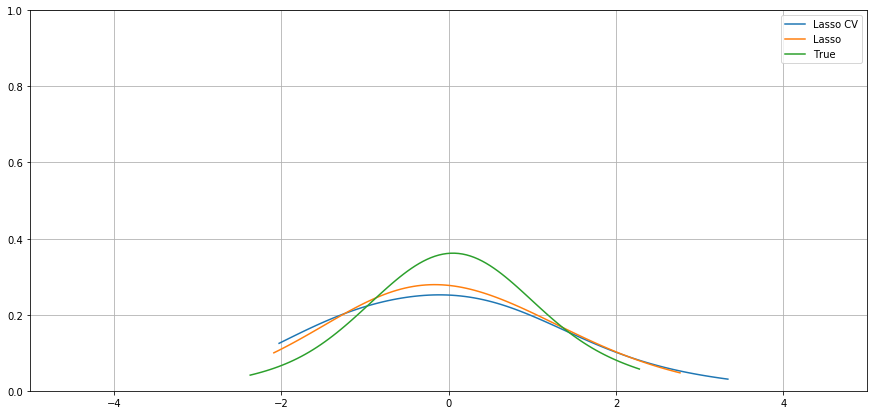

In [40]:
inpt_p_lasso_cv = inpt_p.copy()

inpt_p_lasso = inpt_p.copy()
inpt_p_lasso['cv'] = 0

c_lasso_cv = panel_est(data_pan,data_inst,inpt_p_lasso_cv)
c_lasso = panel_est(data_pan,data_inst,inpt_p_lasso)
c_lasso_cv[3]
i=7
h_c = 1.5
ker = 9

# V_knw = np.array(c_k[2][i-1])
# p_knw = np.linspace(np.min(V_knw),np.max(V_knw),100)
# h_knw = h_c*V_unk.shape[0]**(-1/5)*np.std(V_knw)
# V_knw_den = kr.mvden(V_knw,p_knw,h_knw,ker)

v_lass_cv = np.array(c_lasso_cv[0][i])
p_lass_cv = np.linspace(np.min(v_lass_cv),np.max(v_lass_cv),100)
h_lass_cv = h_c*v_lass_cv.shape[0]**(-1/5)*np.std(v_lass_cv)
v_lass_cv_den = kr.mvden(v_lass_cv,p_lass_cv,h_lass_cv,ker)

v_lass = np.array(c_lasso[0][i])
p_lass = np.linspace(np.min(v_lass),np.max(v_lass),100)
h_lass = h_c*v_lass.shape[0]**(-1/5)*np.std(v_lass)
v_lass_den = kr.mvden(v_lass,p_lass,h_lass,ker)

v_true = data_err.loc[data_err['crs']==i+1,'V1'].values
p_true = np.linspace(np.min(v_true),np.max(v_true),100)
h_true = h_c*v_true.shape[0]**(-1/5)*np.std(v_true)
v_true_den = kr.mvden(v_true,p_true,h_true,ker) 

x_lm = [-5,5]
y_lm = 1

f,ax = plt.subplots()
f.set_figheight(7)
f.set_figwidth(15)
ax.set_xlim((x_lm[0],x_lm[1]))
ax.set_ylim((0,y_lm))
ax.plot(p_lass_cv,v_lass_cv_den)
ax.plot(p_lass,v_lass_den)
ax.plot(p_true,v_true_den)
ax.legend(["Lasso CV","Lasso","True"])
ax.grid(which = 'both')
#ax.set_title(''.join(['Distribution of Estimated ',coeff[0].columns[w]]))
plt.show()

In [41]:
c_lasso_cv[3]

0.5